# Import Modules

In [2]:
!pip install tensorflow==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 19 kB/s 
     |████████████████████████████████| 439 kB 66.3 MB/s 
     |████████████████████████████████| 6.0 MB 60.2 MB/s 
     |████████████████████████████████| 1.7 MB 61.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

In [3]:
import re
import os
import string
import zipfile
import tempfile
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, make_scorer, f1_score

In [4]:
print(f'TF Version: {tf.__version__}\nGPU Config: ')
!nvidia-smi

TF Version: 2.11.0
GPU Config: 
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
print(f'Python version: ')
!python --version

Python version: 
Python 3.8.16


# Loading the data:

In [5]:
df = pd.read_csv('spam_dataset.csv')

In [6]:
df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# check null values
df.isnull().sum()

target     0
message    0
dtype: int64

In [8]:
# Shuffles the dataset
df = df.sample(frac=1).reset_index(drop=True)

#Exploratory Data Analysis:

In [9]:
df.shape

(6700, 2)

In [10]:
df['target'].value_counts(normalize=True)

ham     0.732985
spam    0.267015
Name: target, dtype: float64

As we can see we have a highly imbalanced dataset

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6700 entries, 0 to 6699
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   target   6700 non-null   object
 1   message  6700 non-null   object
dtypes: object(2)
memory usage: 104.8+ KB


As we have both the feilds as Categorical variables. The 'Outcome' variable is an binary feature column which represent whether 

In [12]:
df['target'] = df['target'].map({'ham':0,'spam':1})
df.head()

,target,message
0,0,Ok.ok ok..then..whats ur todays plan
1,0,U still going to the mall?
2,0,"Thanks, I'll keep that in mind"
3,1,"URGENT! Your mobile was awarded a �1,500 Bonus..."
4,1,ATTENTION! Final Few Hours Left! Grab 50% Off*...


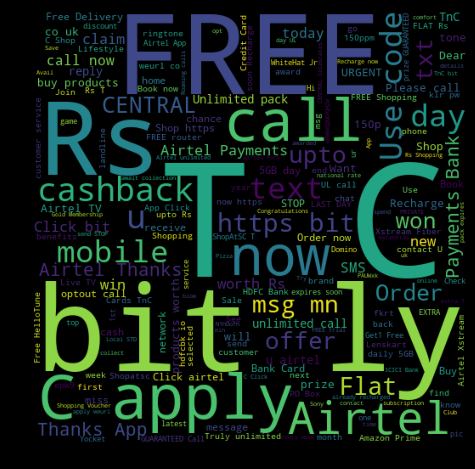

In [13]:
spam_words = ' '.join(list(df[df['target'] == 1]['message']))
spam_wc = WordCloud(width=512, height=512).generate(spam_words)
plt.figure(figsize= (10,8), facecolor='k')
plt.imshow(spam_wc)
plt.show()

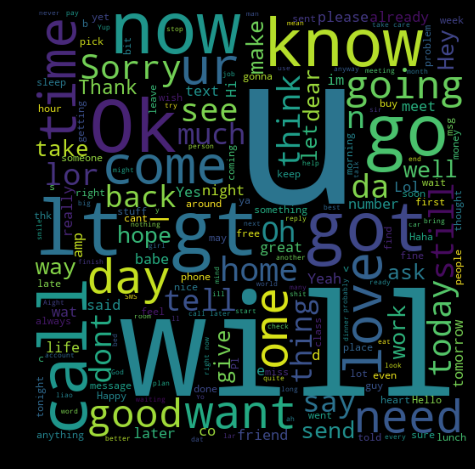

In [14]:
ham_words = ' '.join(list(df[df['target'] == 0]['message']))
ham_wc = WordCloud(width=512, height=512).generate(ham_words)
plt.figure(figsize= (10,8), facecolor='k')
plt.imshow(ham_wc)
plt.show()

# Data Split:

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(df['message'], df['target'],test_size=0.20, random_state=42)

In [14]:
print(f'Number of records in train: {len(X_train)}')
print(f'Number of records in test: {len(X_test)}')

Number of records in train: 5360
Number of records in test: 1340


# Preprocessing and Tokenisation:

Convert the Pandas dataset to Tensorflow Datasets format

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [16]:
for row in train_ds.take(3):
  print(row)

(<tf.Tensor: shape=(), dtype=string, numpy=b'So lets make it saturday or monday as per convenience.'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Use code FLAT100 to buy 3 products worth Rs. 499 & get flat Rs.100 Off*. T&C apply http://msg.mn/8lixNv/N1hOofh'>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Awesome, I remember the last time we got somebody high for the first time with diesel :V'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [17]:
# Tokenisation & Model parameters
max_features = 1000
embedding_dim = 50
sequence_length = 150
batch_size = 32
train_steps = len(X_train) // batch_size
test_steps = len(X_test) // batch_size

# Text Processing Function
@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    remove_special_chars = tf.strings.regex_replace(lowercase, r"[^a-zA-Z0-9 ]", "")
    return tf.strings.regex_replace(
        remove_special_chars, f"[{re.escape(string.punctuation)}]", ""
    )

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
    pad_to_max_tokens=True
)

# The vocab layer has been created, call `adapt` on a text-only dataset to create the vocabulary.

# Let's make a text-only dataset (no labels):
text_only_ds = train_ds.map(lambda x, y: x)
# Let's call `adapt`:
vectorize_layer.adapt(text_only_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
# Vectorized Text
for x,y in train_ds.take(1):
  print(f'Text: {x.numpy()}')
  print(f'Text Vector:\n{vectorize_layer(x)}')
  print(f'label: {y}')

Text: b'So lets make it saturday or monday as per convenience.'
Text Vector:
[ 30 768 147  22 643  28   1  82 215   1   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
label: 0


In [19]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), tf.expand_dims(label, -1)

# Vectorize the data.
train_ds = train_ds.map(vectorize_text)
test_ds = test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.shuffle(buffer_size=1000).repeat().prefetch(buffer_size=10)
test_ds = test_ds.shuffle(buffer_size=1000).repeat().prefetch(buffer_size=10)

# Model Defination & Training:

### LSTM Model

In [22]:
def LSTM_Model(max_features, sequence_length, embedding_dim):
  inputs = tf.keras.layers.Input(name='inputs', shape=(None,))
  x = tf.keras.layers.Embedding(max_features, embedding_dim)(inputs)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
  x = tf.keras.layers.Dense(256, activation="relu")(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(1, name='predictions', activation="sigmoid")(x)
  model = tf.keras.models.Model(inputs=inputs, outputs=x, name='LSTM-Model')

  model.compile(optimizer="adam",
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [22]:
tf.keras.backend.clear_session()
lstm_model = LSTM_Model(max_features, sequence_length, embedding_dim)
lstm_model.summary()

Model: "LSTM-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          50000     
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        58880     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0

In [23]:
history = lstm_model.fit(train_ds,
                         epochs=10,
                         batch_size=32,
                         steps_per_epoch = train_steps,
                         callbacks=[
                             tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001, patience=5)
                             ])

Epoch 1/10
167/167 [==============================] - 22s 60ms/step - loss: 0.4257 - accuracy: 0.7964
Epoch 2/10
167/167 [==============================] - 6s 34ms/step - loss: 0.2903 - accuracy: 0.9042
Epoch 3/10
167/167 [==============================] - 5s 32ms/step - loss: 0.1179 - accuracy: 0.9701
Epoch 4/10
167/167 [==============================] - 6s 34ms/step - loss: 0.1248 - accuracy: 0.9701
Epoch 5/10
167/167 [==============================] - 6s 35ms/step - loss: 0.0371 - accuracy: 0.9940
Epoch 6/10
167/167 [==============================] - 6s 34ms/step - loss: 0.1560 - accuracy: 0.9641
Epoch 7/10
167/167 [==============================] - 5s 31ms/step - loss: 0.1523 - accuracy: 0.9581
Epoch 8/10
167/167 [==============================] - 5s 32ms/step - loss: 0.1072 - accuracy: 0.9701
Epoch 9/10
167/167 [==============================] - 5s 33ms/step - loss: 0.0771 - accuracy: 0.9641
Epoch 10/10
167/167 [==============================] - 6s 33ms/step - loss: 0.1029 - accur

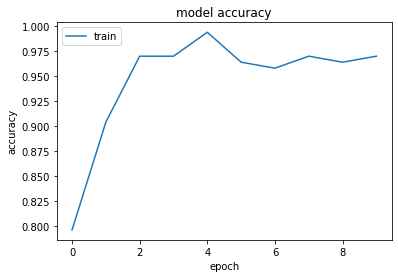

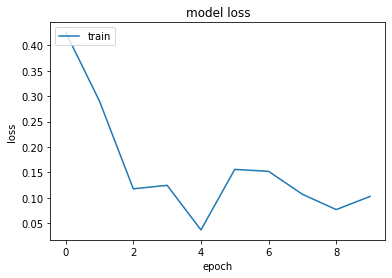

In [24]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [25]:
lstm_model.evaluate(test_ds, steps=test_steps)

41/41 [==============================] - 2s 22ms/step - loss: 0.1471 - accuracy: 0.9512


[0.14708365499973297, 0.9512194991111755]

### Conv Model

In [20]:
def CONV_Model(max_features, sequence_length, embedding_dim):
  inputs = tf.keras.layers.Input(name='inputs', shape=(None,))
  x = tf.keras.layers.Embedding(max_features, embedding_dim)(inputs)

  # Conv1D + global max pooling
  x = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
  x = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
  x = tf.keras.layers.GlobalMaxPooling1D()(x)

  # We add a vanilla hidden layer:
  x = tf.keras.layers.Dense(128, activation="relu")(x)
  x = tf.keras.layers.Dropout(0.5)(x)

  # We project onto a single unit output layer, and squash it with a sigmoid:
  predictions = tf.keras.layers.Dense(1, activation="sigmoid", name="predictions")(x)

  model = tf.keras.Model(inputs, predictions, name="Conv-Model")

  # Compile the model with binary crossentropy loss and an adam optimizer.
  model.compile(loss="binary_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])
  return model

In [21]:
tf.keras.backend.clear_session()
conv_model = CONV_Model(max_features, sequence_length, embedding_dim)
conv_model.summary()

Model: "Conv-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          50000     
                                                                 
 conv1d (Conv1D)             (None, None, 128)         44928     
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                        

In [22]:
history = conv_model.fit(train_ds,
                         epochs=10,
                         batch_size=32,
                         steps_per_epoch = train_steps,
                         callbacks=[
                             tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001, patience=5)
                             ])

Epoch 1/10
167/167 [==============================] - 15s 33ms/step - loss: 0.6131 - accuracy: 0.6946
Epoch 2/10
167/167 [==============================] - 1s 8ms/step - loss: 0.3977 - accuracy: 0.8563
Epoch 3/10
167/167 [==============================] - 1s 7ms/step - loss: 0.1914 - accuracy: 0.9401
Epoch 4/10
167/167 [==============================] - 1s 7ms/step - loss: 0.1892 - accuracy: 0.9341
Epoch 5/10
167/167 [==============================] - 1s 6ms/step - loss: 0.1305 - accuracy: 0.9760
Epoch 6/10
167/167 [==============================] - 1s 7ms/step - loss: 0.2188 - accuracy: 0.9341
Epoch 7/10
167/167 [==============================] - 1s 6ms/step - loss: 0.1536 - accuracy: 0.9521
Epoch 8/10
167/167 [==============================] - 1s 6ms/step - loss: 0.1827 - accuracy: 0.9521
Epoch 9/10
167/167 [==============================] - 1s 6ms/step - loss: 0.1308 - accuracy: 0.9641
Epoch 10/10
167/167 [==============================] - 1s 5ms/step - loss: 0.1603 - accuracy: 0.96

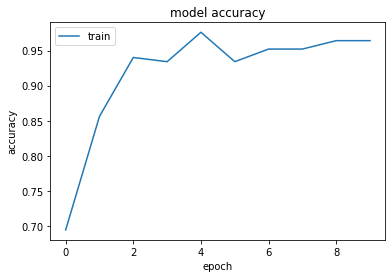

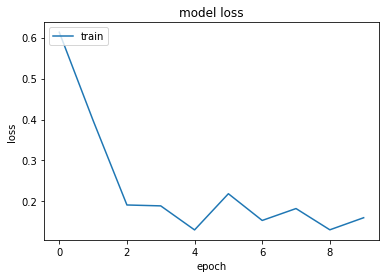

In [23]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [24]:
conv_model.evaluate(test_ds, steps=test_steps)

41/41 [==============================] - 0s 3ms/step - loss: 0.0257 - accuracy: 1.0000


[0.02565542422235012, 1.0]

# End-to-End Model:

Combining Text Vectorization layer & TF Model into one model

In [25]:
def build_end_to_end_model(model, vector_layer, model_name):
  # A string input
  inputs = tf.keras.Input(shape=(1,), dtype="string", name='StringInput')

  # Turn strings into vocab indices
  indices = vector_layer(inputs)

  # Turn vocab indices into predictions
  outputs = model(indices)

  end_to_end_model = tf.keras.Model(inputs, outputs, name=model_name)
  end_to_end_model.compile(
      loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
      )
  return end_to_end_model

In [26]:
tf.keras.backend.clear_session()
# lstm_spam_detector = build_end_to_end_model(lstm_model, vectorize_layer, model_name='LSTM-SPAM-MODEL')
conv_spam_detector = build_end_to_end_model(conv_model, vectorize_layer, model_name='CONV-SPAM-MODEL')

In [27]:
lstm_spam_detector.summary()

NameError: ignored

In [28]:
conv_spam_detector.summary()

Model: "CONV-SPAM-MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 StringInput (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 150)              0         
 torization)                                                     
                                                                 
 Conv-Model (Functional)     (None, 1)                 226385    
                                                                 
Total params: 226,385
Trainable params: 226,385
Non-trainable params: 0
_________________________________________________________________


# Evaluation:

In [29]:
def get_true_and_pred_values(text_data: pd.Series, labels: pd.Series, model: tf.keras.Model, threshold:int=0.75):

  x = model.predict(text_data.values)
  preds = [1 if i[0] > threshold else 0 for i in x]
  return labels, preds

### LSTM Model

In [36]:
y_true, y_pred = get_true_and_pred_values(X_test, Y_test, lstm_spam_detector)

42/42 [==============================] - 2s 14ms/step


Classification Report

In [37]:
target_names = ['Ham', 'Spam']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         Ham       0.85      1.00      0.92      1001
        Spam       1.00      0.50      0.67       339

    accuracy                           0.87      1340
   macro avg       0.93      0.75      0.79      1340
weighted avg       0.89      0.87      0.86      1340



In [38]:
x = lstm_spam_detector.predict(X_test.values)
predict_probs = [i[0] for i in x]

42/42 [==============================] - 1s 14ms/step


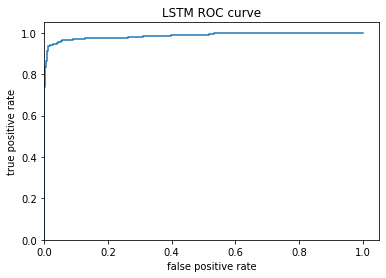

In [39]:
fpr, tpr, _ = roc_curve(y_true, predict_probs)
plt.plot(fpr, tpr)
plt.title('LSTM ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

### Conv Model

In [30]:
y_true, y_pred = get_true_and_pred_values(X_test, Y_test, conv_spam_detector)

42/42 [==============================] - 0s 3ms/step


Classification Report

In [31]:
target_names = ['Ham', 'Spam']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         Ham       0.98      0.99      0.98       973
        Spam       0.98      0.93      0.96       367

    accuracy                           0.98      1340
   macro avg       0.98      0.96      0.97      1340
weighted avg       0.98      0.98      0.98      1340



In [32]:
x = conv_spam_detector.predict(X_test.values)
predict_probs = [i[0] for i in x]

42/42 [==============================] - 0s 3ms/step


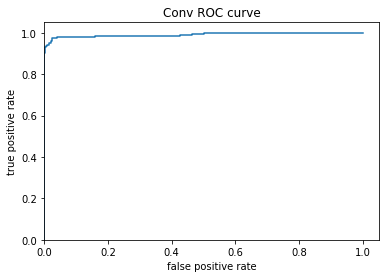

In [33]:
fpr, tpr, _ = roc_curve(y_true, predict_probs)
plt.plot(fpr, tpr)
plt.title('Conv ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

# K-Fold Crossvalidation:

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
def get_k_fold_statistics(raw_x, raw_y, 
                          vectorizer: tf.keras.layers=vectorize_layer, 
                          folds:int=10, max_features:int = 1000, 
                          embedding_dim:int = 50,
                          sequence_length:int = 150, 
                          batch_size:int=32,
                          epochs_to_train:int=10):
  
  # Use the existing vectorizer and then make the K-Folds and K-Models
  
  kfold_f1_scores = []

  def build_new_end_to_end_model(raw_model:tf.keras.Model, fold_num:int):
    inputs = tf.keras.Input(shape=(1,), dtype="string", name='StringInput')
    indices = vectorizer(inputs)
    outputs = raw_model(indices)
    end_to_end_model = tf.keras.Model(inputs, outputs, name=f'model_{fold_num}')
    end_to_end_model.compile(
        loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
        )
    return end_to_end_model
  
  kf = KFold(n_splits=folds, shuffle=True)

  for fold_num, (train_index, test_index) in enumerate(kf.split(raw_x)):
    print(f'Current Fold: {fold_num}')
    X_train, X_test = raw_x.iloc[train_index], raw_x.iloc[test_index]
    Y_train, Y_test = raw_y.iloc[train_index], raw_y.iloc[test_index]

    raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    train_ds = raw_train_ds.map(vectorize_text)
    train_ds = train_ds.shuffle(buffer_size=1000).repeat().prefetch(buffer_size=10)

    model = CONV_Model(max_features, sequence_length, embedding_dim)

    model.fit(train_ds,
              epochs=epochs_to_train,
              batch_size=raw_x,
              steps_per_epoch = len(raw_x) // batch_size,
              callbacks=[
                  tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001, patience=5)
                  ])
    
    complete_model = build_new_end_to_end_model(model, fold_num)
    y_true, y_pred = get_true_and_pred_values(X_test, Y_test, complete_model)
    kfold_f1_scores.append(f1_score(y_true, y_pred))
  
  return kfold_f1_scores

### LSTM 10 Fold

In [ ]:
lstm_f1_scores = get_k_fold_statistics(X_train, Y_train)

Current Fold: 0
Epoch 1/10
167/167 [==============================] - 11s 32ms/step - loss: 0.4864 - accuracy: 0.7485
Epoch 2/10
167/167 [==============================] - 5s 31ms/step - loss: 0.2599 - accuracy: 0.9222
Epoch 3/10
167/167 [==============================] - 5s 30ms/step - loss: 0.1743 - accuracy: 0.9641
Epoch 4/10
167/167 [==============================] - 5s 32ms/step - loss: 0.0882 - accuracy: 0.9701
Epoch 5/10
167/167 [==============================] - 5s 31ms/step - loss: 0.1188 - accuracy: 0.9521
Epoch 6/10
167/167 [==============================] - 5s 31ms/step - loss: 0.2179 - accuracy: 0.9401
Epoch 7/10
167/167 [==============================] - 5s 31ms/step - loss: 0.0873 - accuracy: 0.9701
Epoch 8/10
167/167 [==============================] - 5s 31ms/step - loss: 0.0996 - accuracy: 0.9581
Epoch 9/10
167/167 [==============================] - 5s 31ms/step - loss: 0.1182 - accuracy: 0.9581
Epoch 10/10
17/17 [==============================] - 1s 16ms/step
Current 

In [ ]:
print(f'Mean F1 score for LSTM Model: {np.mean(lstm_f1_scores)}')
print(f'Median F1 score for LSTM Model: {np.median(lstm_f1_scores)}')

Mean F1 score for LSTM Model: 0.9328209291516061
Median F1 score for LSTM Model: 0.9398698862692025


### Conv 10 Fold

In [ ]:
conv_f1_scores = get_k_fold_statistics(X_train, Y_train)

Current Fold: 0
Epoch 1/10
167/167 [==============================] - 1s 4ms/step - loss: 0.5744 - accuracy: 0.7844
Epoch 2/10
167/167 [==============================] - 1s 5ms/step - loss: 0.3044 - accuracy: 0.8743
Epoch 3/10
167/167 [==============================] - 1s 4ms/step - loss: 0.2390 - accuracy: 0.9281
Epoch 4/10
167/167 [==============================] - 1s 5ms/step - loss: 0.2447 - accuracy: 0.8922
Epoch 5/10
167/167 [==============================] - 1s 4ms/step - loss: 0.2123 - accuracy: 0.9341
Epoch 6/10
167/167 [==============================] - 1s 4ms/step - loss: 0.1491 - accuracy: 0.9760
Epoch 7/10
167/167 [==============================] - 1s 4ms/step - loss: 0.1548 - accuracy: 0.9521
Epoch 8/10
167/167 [==============================] - 1s 5ms/step - loss: 0.1576 - accuracy: 0.9641
Epoch 9/10
167/167 [==============================] - 1s 5ms/step - loss: 0.0948 - accuracy: 0.9641
Epoch 10/10
17/17 [==============================] - 0s 4ms/step
Current Fold: 1
Epo

In [ ]:
print(f'Mean F1 score for Conv Model: {np.mean(conv_f1_scores)}')
print(f'Median F1 score for Conv Model: {np.median(conv_f1_scores)}')

Mean F1 score for Conv Model: 0.9295984773870745
Median F1 score for Conv Model: 0.9351981351981352


K-Fold Mean and Median for both the models are identical. However the Conv Model shows a better F1 score for individial Spam and Ham classes, when compared to LSTM Model. Hence we select to move with Conv Model

# Inference:

In [34]:
def inference(text:str, model:tf.keras.Model, threshold:int=0.75):
  prediction = model.predict([text])
  score = prediction[0][0]
  return "spam" if score > threshold else "ham"

In [35]:
input_text = 'Want to find the right university to upskill your future? Join this session with Yocket to understand the needs of tomorrow and find the right career path today! https:www.yocket/webinar/05328'

inference(text=input_text,
          model=conv_spam_detector)

1/1 [==============================] - 0s 31ms/step


'spam'

# Post Training Pruning

In [36]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 238 kB 35.6 MB/s 


In [37]:
_, baseline_model_accuracy = conv_spam_detector.evaluate(
    X_test, Y_test)

print('Baseline test accuracy:', baseline_model_accuracy)

42/42 [==============================] - 0s 4ms/step - loss: 0.0829 - accuracy: 0.9716
Baseline test accuracy: 0.9716417789459229


In [38]:
conv_spam_detector.save('saved_model/conv_spam_detector')

In [39]:
import tensorflow_model_optimization as tfmot

In [40]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 10

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=train_steps*epochs)
}

model_for_pruning = prune_low_magnitude(conv_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "Conv-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None)]            0         
                                                                 
 prune_low_magnitude_embeddi  (None, None, 50)         100002    
 ng (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_conv1d   (None, None, 128)        89730     
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_conv1d_  (None, None, 128)        229506    
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_global_  (None, 128)              1         
 max_pooling1d (PruneLowMagn                            

In [41]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_ds,
                  epochs=10,
                  batch_size=32,
                  steps_per_epoch = train_steps,
                  callbacks=callbacks)

Epoch 1/10
167/167 [==============================] - 13s 28ms/step - loss: 0.1423 - accuracy: 0.9820
Epoch 2/10
167/167 [==============================] - 1s 8ms/step - loss: 0.0370 - accuracy: 0.9820
Epoch 3/10
167/167 [==============================] - 2s 10ms/step - loss: 0.0890 - accuracy: 0.9880
Epoch 4/10
167/167 [==============================] - 1s 8ms/step - loss: 0.0734 - accuracy: 0.9760
Epoch 5/10
167/167 [==============================] - 1s 8ms/step - loss: 0.0930 - accuracy: 0.9701
Epoch 6/10
167/167 [==============================] - 1s 8ms/step - loss: 0.0299 - accuracy: 0.9940
Epoch 7/10
167/167 [==============================] - 2s 10ms/step - loss: 0.0567 - accuracy: 0.9820
Epoch 8/10
167/167 [==============================] - 1s 9ms/step - loss: 0.0221 - accuracy: 1.0000
Epoch 9/10
167/167 [==============================] - 1s 8ms/step - loss: 0.1319 - accuracy: 0.9701
Epoch 10/10
167/167 [==============================] - 1s 9ms/step - loss: 0.0770 - accuracy: 0.

In [42]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_ds, steps=test_steps)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

41/41 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 1.0000
Baseline test accuracy: 0.9716417789459229
Pruned test accuracy: 1.0


In [43]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

In [44]:
tf.keras.models.save_model(
    model_for_export,
    '/content/saved_model/pruned_model/',
    overwrite=True,
    include_optimizer=False,
    save_format='tf',
    signatures=None,
    options=None,
    save_traces=True
)

In [45]:
loaded_pruned_model = tf.keras.models.load_model('/content/saved_model/pruned_model/')

In [46]:
conv_pruned_spam_detector = build_end_to_end_model(model_for_export, vectorize_layer, model_name='CONV-PRUNED-SPAM-MODEL')

In [47]:
input_text = 'Want to find the right university to upskill your future? Join this session with Yocket to understand the needs of tomorrow and find the right career path today! https:www.yocket/webinar/05328'

inference(text=input_text,
          model=conv_pruned_spam_detector)

1/1 [==============================] - 0s 132ms/step


'spam'

In [48]:
conv_pruned_spam_detector.save('/content/saved_model/pruned_spam_detector/')

In [49]:
loaded_pruned_detector = tf.keras.models.load_model('/content/saved_model/pruned_spam_detector/')

In [50]:
input_text = 'Want to find the right university to upskill your future? Join this session with Yocket to understand the needs of tomorrow and find the right career path today! https:www.yocket/webinar/05328'

inference(text=input_text,
          model=loaded_pruned_detector)

1/1 [==============================] - 0s 265ms/step


'spam'

In [51]:
!zip -r /content/spam_detector.zip /content/saved_model/pruned_spam_detector

  adding: content/saved_model/pruned_spam_detector/ (stored 0%)
  adding: content/saved_model/pruned_spam_detector/saved_model.pb (deflated 87%)
  adding: content/saved_model/pruned_spam_detector/fingerprint.pb (stored 0%)
  adding: content/saved_model/pruned_spam_detector/variables/ (stored 0%)
  adding: content/saved_model/pruned_spam_detector/variables/variables.data-00000-of-00001 (deflated 70%)
  adding: content/saved_model/pruned_spam_detector/variables/variables.index (deflated 52%)
  adding: content/saved_model/pruned_spam_detector/assets/ (stored 0%)
  adding: content/saved_model/pruned_spam_detector/keras_metadata.pb (deflated 92%)


In [53]:
print(f'Final Model Size: {os.path.getsize("/content/spam_detector.zip")} bytes')

Final Model Size: 317076 bytes


# Testing Loaded Model

Load the model only in TF - v2.11, as the model was trained in TF - v2.11

In [1]:
!pip install tensorflow==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 20 kB/s 
     |████████████████████████████████| 439 kB 68.2 MB/s 
     |████████████████████████████████| 6.0 MB 56.8 MB/s 
     |████████████████████████████████| 1.7 MB 55.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

In [2]:
import re
import string
import tensorflow as tf
print(f'TF version: {tf.__version__}')

TF version: 2.11.0


In [3]:
!unzip /content/spam_detector.zip

Archive:  /content/spam_detector.zip
   creating: content/saved_model/pruned_spam_detector/
  inflating: content/saved_model/pruned_spam_detector/saved_model.pb  
 extracting: content/saved_model/pruned_spam_detector/fingerprint.pb  
   creating: content/saved_model/pruned_spam_detector/variables/
  inflating: content/saved_model/pruned_spam_detector/variables/variables.data-00000-of-00001  
  inflating: content/saved_model/pruned_spam_detector/variables/variables.index  
   creating: content/saved_model/pruned_spam_detector/assets/
  inflating: content/saved_model/pruned_spam_detector/keras_metadata.pb  


In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
@tf.keras.utils.register_keras_serializable(package='Custom', name='custom_standardization')
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    remove_special_chars = tf.strings.regex_replace(lowercase, r"[^a-zA-Z0-9 ]", "")
    return tf.strings.regex_replace(
        remove_special_chars, f"[{re.escape(string.punctuation)}]", ""
    )

In [6]:
def inference(text:str, model:tf.keras.Model, threshold:int=0.75):
  prediction = model.predict([text])
  score = prediction[0][0]
  return "spam" if score > threshold else "ham"

In [7]:
with tf.keras.utils.custom_object_scope({'custom_standardization': custom_standardization}):
  loaded_pruned_detector = tf.keras.models.load_model('/content/content/saved_model/pruned_spam_detector')

In [8]:
input_text = 'Want to find the right university to upskill your future? Join this session with Yocket to understand the needs of tomorrow and find the right career path today! https:www.yocket/webinar/05328'

inference(text=input_text,
          model=loaded_pruned_detector)

1/1 [==============================] - 0s 219ms/step


'spam'